In [178]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from imageio import imread
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")

In [179]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [180]:
def design_matrix(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)		# Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

# Regular Test Over Poly Degree (No Resampling)

In [190]:
def Lasso_test_poly_degree(npoints, lower, upper, noise, sigma, nalphas, scaling):

    np.random.seed(1)

    test_MSEs = []
    train_MSEs = []

    poly_order_range = range(lower, upper + 1)

    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)
    x_gr, y_gr = np.meshgrid(x,y)

    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(y)))

    for order in poly_order_range:
        X = design_matrix(x, y, order)
        X_train_origin, X_test_origin, z_train_origin, z_test_origin = train_test_split(X, z, test_size = 0.3, random_state = 1)

        X_train = X_train_origin - scaling * np.mean(X_train_origin, axis=0)
        X_test = X_test_origin - scaling * np.mean(X_train_origin, axis=0)
        z_train = z_train_origin - scaling * np.mean(z_train_origin, axis=0)
        z_test = z_test_origin - scaling * np.mean(z_train_origin, axis=0)

        I = np.eye(X_train.shape[1],X_train.shape[1])

        test_MSEs_temp = np.zeros(nalphas)
        train_MSEs_temp = np.zeros(nalphas)
        test_R2s_temp = np.zeros(nalphas)
        train_R2s_temp = np.zeros(nalphas)

        alphas = np.logspace(-4, 1, nalphas)

        for i in range(nalphas):
            alp = alphas[i]
            model = Lasso(alpha = alp)
            model.fit(X_train, z_train)

            ztilde_Lasso = model.predict(X_train)
            zpredict_Lasso = model.predict(X_test)

            test_MSEs_temp[i] = MSE(z_test,zpredict_Lasso)
            train_MSEs_temp[i] = MSE(z_train,ztilde_Lasso)

        train_MSEs.append(train_MSEs_temp)
        test_MSEs.append(test_MSEs_temp)

    train_MSEs = np.array(train_MSEs)
    test_MSEs = np.array(test_MSEs)

    return test_MSEs, train_MSEs, alphas

In [191]:
npoints = 100
lower = 1
upper = 5
noise = 1
sigma = 0.1
nalphas = 20
scaling = 1

test_MSEs, train_MSEs, alphas = Lasso_test_poly_degree(npoints, lower, upper, noise, sigma, nalphas, scaling)

Text(0.5, 43.0, '$\\alpha$')

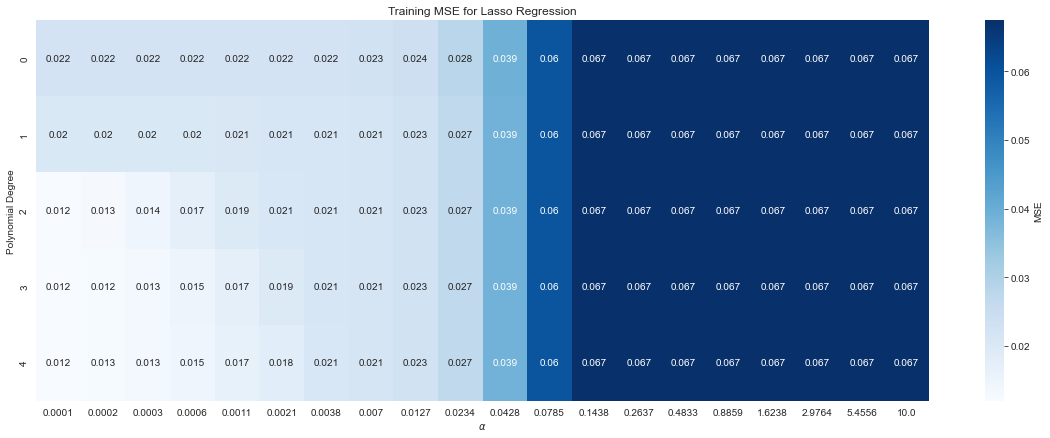

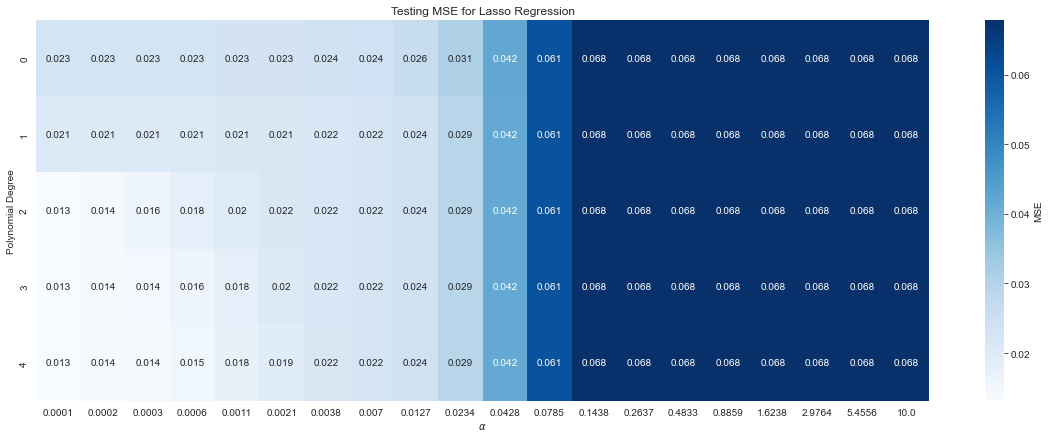

In [192]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(train_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'})
ax.set_title("Training MSE for Lasso Regression")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(test_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'})
ax.set_title("Testing MSE for Lasso Regression")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")

# Bootstrap Resampling

In [188]:
def Lasso_test_bootstrap(npoints, lower, upper, noise, sigma, nalphas, scaling, nbootstraps):

    np.random.seed(1)
    test_MSEs = []
    train_MSEs = []
    poly_order_range = range(lower, upper+1)

    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)
    x_gr, y_gr = np.meshgrid(x,y)

    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, 0.1, (len(x),len(x)))
    count = 0
    for order in poly_order_range:

        X = design_matrix(x, y, order)

        X_train_origin, X_test_origin, z_train_origin, z_test_origin = train_test_split(X, z, test_size = 0.3, random_state = 1)

        X_train = X_train_origin - scaling *  np.mean(X_train_origin, axis=0)
        X_test = X_test_origin - scaling *  np.mean(X_train_origin, axis=0)
        z_train = z_train_origin - scaling *  np.mean(z_train_origin, axis=0)
        z_test = z_test_origin - scaling *  np.mean(z_train_origin, axis=0)

        mse_temp_alp_test = np.zeros(nalphas)
        mse_temp_alp_train = np.zeros(nalphas)

        alphas = np.logspace(-4, 1, nalphas)

        for i in range(nalphas):

            alp = alphas[i]
            mse_temp_boot_test = np.zeros(nbootstraps)
            mse_temp_boot_train = np.zeros(nbootstraps)
            for j in range(nbootstraps):
                X_train_, z_train_ = resample(X_train, z_train)

                model = Lasso(alpha = alp)
                model.fit(X_train_, z_train_)

                ztilde_Lasso = model.predict(X_train_)
                zpredict_Lasso = model.predict(X_test)

                mse_temp_boot_test[j] = MSE(z_test, zpredict_Lasso)
                mse_temp_boot_train[j] = MSE(z_train_, ztilde_Lasso)

            mse_temp_alp_test[i] = np.mean(mse_temp_boot_test)
            mse_temp_alp_train[i] = np.mean(mse_temp_boot_train)

        test_MSEs.append(mse_temp_alp_test)
        train_MSEs.append(mse_temp_alp_train)

        count += 1
        print(count)

    test_MSEs = np.array(test_MSEs)
    train_MSEs = np.array(train_MSEs)

    return test_MSEs, train_MSEs, alphas

In [189]:
npoints = 100
lower = 1
upper = 5
noise = 1
sigma = 0.1
nalphas = 20
scaling = 1
nbootstraps = 100

bootstrap_test_MSEs, bootstrap_train_MSEs, biases, variances, alphas = Lasso_test_bootstrap(npoints, lower, upper, noise, sigma, nalphas, scaling, nbootstraps)

1
2
3
4
5


ValueError: not enough values to unpack (expected 5, got 3)

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(bootstrap_train_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'})
ax.set_title("Bootstrap - Training MSE for Lasso Regression")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(bootstrap_test_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'})
ax.set_title("Bootstrap - Testing MSE for Lasso Regression")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")

## Bootstrap resampling extended version

In [ ]:
def lasso_test_bootstrap(npoints, lower, upper, noise, sigma, nalphas, nbootstraps, scaling):

    np.random.seed(1)
    errors = []
    train_errors = []
    biases = []
    variances = []
    poly_order_range = range(lower, upper+1)

    n_bootstraps = nbootstraps

    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)
    x_gr, y_gr = np.meshgrid(x,y)

    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, 0.1, (len(x),len(x)))

    for order in poly_order_range:

        X = design_matrix(x, y, order)

        X_train_origin, X_test_origin, z_train_origin, z_test_origin = train_test_split(X, z, test_size = 0.2, random_state = 1)

        X_train = X_train_origin - scaling * np.mean(X_train_origin, axis=0)
        X_test = X_test_origin - scaling * np.mean(X_train_origin, axis=0)
        z_train = z_train_origin - scaling * np.mean(z_train_origin, axis=0)
        z_test = z_test_origin - scaling * np.mean(z_train_origin, axis=0)

        z_test = np.expand_dims(z_test, 2)

        z_pred = np.empty((z_test.shape[0], npoints, n_bootstraps))

        I = np.eye(X_train.shape[1],X_train.shape[1])

        error_temp = np.zeros(nalphas)
        train_error_temp = np.zeros(nalphas)
        bias_temp = np.zeros(nalphas)
        variance_temp = np.zeros(nalphas)

        alphas = np.logspace(-4, 1, nalphas)

        for i in range(nalphas):

            alp = alphas[i]
            for j in range(n_bootstraps):
                X_train_, z_train_ = resample(X_train, z_train)

                model = Lasso(alpha = alp)
                model.fit(X_train_, z_train_)

                z_tilde = model.predict(X_train_)
                z_pred[:, :, j] = model.predict(X_test)

            train_error_temp[i] = np.mean( np.mean((z_tilde - z_train_)**2, axis=1) )
            error_temp[i] = np.mean( np.mean((z_test - z_pred)**2, axis=2) )
            bias_temp[i] = np.mean( (z_test - np.mean(z_pred, axis=2, keepdims=True))**2 )
            variance_temp[i] = np.mean( np.var(z_pred, axis=2, keepdims=True) )

        train_errors.append(train_error_temp)
        errors.append(error_temp)
        biases.append(bias_temp)
        variances.append(variance_temp)

    train_errors = np.array(train_errors)
    errors = np.array(errors)
    biases = np.array(biases)
    variances = np.array(variances)

    return errors, train_errors, biases, variances, alphas

In [ ]:
npoints = 100
lower = 1
upper = 5
nbootstraps = 100
noise = 1
sigma = 0.1
nalphas = 20


bootstrap_test_MSEs, bootstrap_train_MSEs, biases, variances, alphas = lasso_test_bootstrap(npoints,
                                    lower, upper, noise, sigma, nalphas, nbootstraps, scaling = 1)

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(bootstrap_train_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'})
ax.set_title("Bootstrap - Training MSE for Lasso Regression")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(bootstrap_test_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'})
ax.set_title("Bootstrap - Testing MSE for Lasso Regression")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")

In [ ]:
n = 2
poly_order_range = range(1,9)
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(poly_order_range, bootstrap_test_MSEs[:,n], color='darkred', label='MSE')
ax.plot(poly_order_range, biases[:,n], color='turquoise', label='bias')
ax.plot(poly_order_range, variances[:,n], color='darkorange', label='variance')
#ax.vlines(3, -1, 1, color='grey', linestyles='--')
#ax.set_ylim(-0.001, 0.05)
ax.legend()
ax.set_xlabel('Polynomial Order')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Bias Variance Tradeoff Demonstrated for Lasso')

# Cross Validation with unbiased mean calculation

In [ ]:
def Lasso_CV(npoints, lower, upper, noise, sigma, nalphas, scaling, nfolds):

    np.random.seed(1)

    poly_order_range = range(lower, upper+1)
    k = nfolds
    kfold = KFold(n_splits = k)
    scores_KFold_train = np.zeros((len(poly_order_range), nalphas, k))
    scores_KFold_test = np.zeros((len(poly_order_range), nalphas, k))

    x = np.linspace(0, 1, npoints)
    y = np.linspace(0, 1, npoints)

    x_gr, y_gr = np.meshgrid(x,y)

    z = FrankeFunction(x_gr, y_gr) + noise*np.random.normal(0, sigma, (len(x),len(x)))
    count = 0
    for order in poly_order_range:

        X = design_matrix(x, y, order)

        alphas = np.logspace(-4, 1, nalphas)

        for i in range(nalphas):

            alp = alphas[i]
            j = 0
            for train_inds, test_inds in kfold.split(X):

                X_train_origin = X[train_inds]
                z_train_origin = z[train_inds]
                X_test_origin = X[test_inds]
                z_test_origin = z[test_inds]

                X_train = X_train_origin - scaling *  np.mean(X_train_origin, axis=0)
                X_test = X_test_origin - scaling *  np.mean(X_train_origin, axis=0)
                z_train = z_train_origin - scaling *  np.mean(z_train_origin, axis=0)
                z_test = z_test_origin - scaling *  np.mean(z_train_origin, axis=0)

                model = Lasso(alpha = alp)
                model.fit(X_train, z_train)

                ztilde_Lasso = model.predict(X_train)
                zpredict_Lasso = model.predict(X_test)

                scores_KFold_test[order-1, i, j] =  MSE(zpredict_Lasso, z_test)
                scores_KFold_train[order-1, i, j] =  MSE(ztilde_Lasso, z_train)

                j += 1
            i += 1

        count += 1
        print(count)

    estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 2)
    estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 2)

    return estimated_mse_KFold_test, estimated_mse_KFold_train

In [ ]:
npoints = 100
lower = 1
upper = 5
noise = 1
sigma = 0.1
nalphas = 20
scaling = 1
nfolds = 10

cv_test_MSEs, cv_train_MSEs = Lasso_CV(npoints, lower, upper, noise, sigma, nalphas, scaling, nfolds)

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(cv_train_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'}, vmin=cv_train_MSEs.min(), vmax=cv_train_MSEs.max())
ax.set_title("Cross Validation - Training MSE for Lasso Regression with unbiased mean")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(cv_test_MSEs, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': 'MSE'}, vmin=cv_test_MSEs.min(), vmax=cv_test_MSEs.max())
ax.set_title("Cross Validation - Testing MSE for Lasso Regression with unbiased mean")
ax.set_xticklabels(alphas.round(4))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$\\alpha$")